
Luciano Pinheiro 173096


# Parte 1

 Primeiramente as amostras da série temporal do arquivo *mackeyglass.csv* foram divididas em amostras de teste e amostras de treinamento. Estas últimas, por sua vez, foram divididas entre amostras efetivamente utilizadas para a aproximação e amostras utilizadas para a validação seguindo o método *Holdout*, com divisão de **70%** para a aproximação e **30%** para a validação.
 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

mg_df = pd.read_csv('mackeyglass.csv')

P = mg_df.p.values

#Separação entre dados de teste e dados de validação
P_teste = P[int(0.75*len(P)):len(P)]
P_treino = P[0:int(0.75*len(P))]

#Separação das amostras que vão ser efeitivamente utilizadas para a aproximação e as amostras para validação
P_aprox =  P_treino[0:int(0.7*len(P_treino))]
P_valid =  P_treino[int(0.7*len(P_treino)):len(P_treino)]


Seguiu-se então para a etapa de treinamento. A função **Entrada_Saida_Aprox** divide, com base nos hiperparâmetros $K$ e $L$, as amostras de aproximação entre os atributos de entrada e a sua respectiva saída. Já a função **Calcula_Param**, recebe as entradas e saídas corretamente divididas e realiza o cálculo dos parâmetros da aproximação linear segundo o critério de quadrados mínimos. Isto foi feito para $K$ variando de $1$ até $50$, sendo os atributos gerados guardados na variável $W$.


In [2]:
#Treinamento
def Entrada_Saida_Aprox(K, L):
    x = np.zeros([1, K])
    y = np.zeros([1])
    for i in range(len(P_aprox)-K-L+1):
        xr = np.array([])
        for j in range(K):
            xr = np.append(xr, P_aprox[i+j])
        x = np.vstack((x, xr))
        y = np.vstack((y, P_aprox[i+K+L-1]))
    x = x[1:len(x)]
    y = y[1:len(y)]
    return(x, y)

def Calcula_Param(x, y):
    temp = np.ones((len(x), 1))
    fi = np.concatenate((temp, x), axis = 1)
    aux = np.matmul(fi.T, fi)
    FI = np.matmul(np.linalg.inv(aux), fi.T)
    w = np.matmul(FI, y)
    return (w)
    
L = 7
W = np.zeros([51, 1])
for K in range(1, 51, 1):
    (x, y) = Entrada_Saida_Aprox(K, L)
    w = Calcula_Param(x, y)
    Completa_w = np.zeros([51-len(w), 1])
    w = np.vstack((w, Completa_w))
    W = np.hstack((W,w))

    


Após o treinamento foi realizada a etapa de validação. Para isso os parâmetros calculados para cada $K$ foram extraídos da variável $W$ pela função **Desempacota_Parametros** e em seguida a função **Calcula_Saidas** foi utilizada para calcular as saídas valendo-se dos parâmetros obtidos na etapa anterior e das amostras de validação. Além disso, esta função também retorna o valor esperado da série. Com posse dos valores calculados e esperados, a função **Calcula_RMSE** foi utilizada para o cálculo da $RMSE$, e o gráfico de $RMSE$ em função de $K$, foi gerado. Percebe-se que a $RMSE$ inicia-se um pouco alta e decai, permanecendo de certo modo constante para $K$ entre $10$ e $30$. Após isso a $RMSE$ cresce bastante.


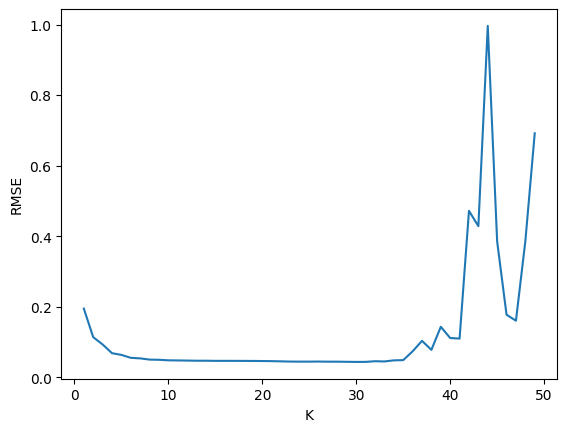

In [3]:
#Validação
def Desempacota_Parametros(K, W):
    w = W[:, K]
    w = w[0:K+1]
    w = np.reshape(w, (len(w), 1))
    return w

def Calcula_Saidas(w, K, L):
    Y = []
    for i in range(len(P_valid)-K-L+1):
        x = np.array([1])
        for j in range(K):
            x = np.append(x, P_valid[i+j])
        x = np.reshape(x, (len(x), 1))
        y_calc = np.dot(w.T,x)  
        y_calc = np.ndarray.tolist(y_calc[0])
        y_esperado = P_valid[i+K+L-1]
        Y.append((y_calc[0], y_esperado))
    return(Y)

def Calcula_RMSE(Y):
    e = 0
    for y in Y:
        y_calc, y_esp = y
        e += (y_calc - y_esp)**2
    e = e/len(Y)
    e = e**(1/2)
    return e

E = []
ks = []
for K in range(1, 50, 1):
    w = Desempacota_Parametros(K, W)
    Y = Calcula_Saidas(w, K, L)
    E.append(Calcula_RMSE(Y))
    ks.append(K)
    
fig, ax = plt.subplots()
ax.plot(ks, E)
ax.set_ylabel('RMSE')
ax.set_xlabel('K')
plt.show()
    

Finalmente, para a etapa de teste foi utilizado $K = 30$, sendo este o que gerou o menor erro, $RMSE = 0.044$. A função **Calcula_Saidas_Teste** foi utilizada para dividir corretamente os atributos e as saídas calculadas e esperadas com base nas amostras de teste. Assim, o gráfico entre as saídas esperadas - em azul - e as calculadas - em vermelho - foi gerado. A aproximação calculada se mostrou boa ao conseguir acompanhar o padrão geral da série na maior parte do gráfico. Contudo, percebe-se que alguns picos da série original foram distorcidos pela série calculada.

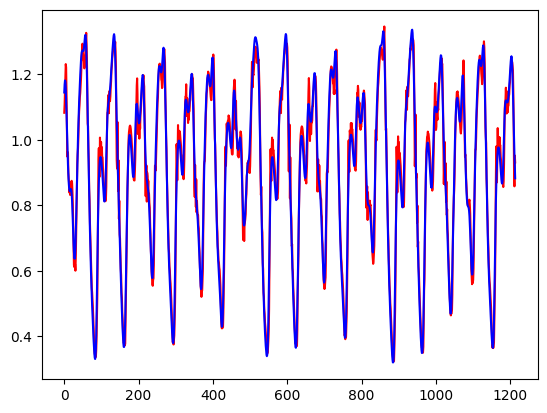

In [4]:
#Comparação com amostras de teste para K = 30
def Calcula_Saidas_teste(w, K, L):
    Y_esp = []
    Y_calc = []
    for i in range(len(P_teste)-K-L+1):
        x = np.array([1])
        for j in range(K):
            x = np.append(x, P_teste[i+j])
        x = np.reshape(x, (len(x), 1))
        y_calc = np.dot(w.T,x)
        Y_calc = np.append(Y_calc, y_calc)
        Y_esp = np.append(Y_esp, P_teste[i+K+L-1])
    return Y_calc, Y_esp


K = 30
w = Desempacota_Parametros(K, W)
y_calculado, y_esperado = Calcula_Saidas_teste(w, K, L)

t = np.arange(len(y_calculado))
fig, bx = plt.subplots()
bx.plot(t, y_calculado, color = "red")
bx.plot(t, y_esperado, color = "blue")
plt.show()
